# Dashboard Profile completion

In [1]:
import pymysql.cursors

import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime
import lifetimes
#import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn-whitegrid')
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import plotly
plotly.tools.set_config_file(world_readable=True , sharing='public')

In [2]:
connect_sql = pymysql.connect(host='prd-db-olxin-replica-1.cnhuszkczyjo.ap-southeast-1.rds.amazonaws.com',
                            user='dev',
                            password='^b6W2vVuM4KJ',
                            db='olxin',
                            charset='utf8mb4',
                            cursorclass=pymysql.cursors.DictCursor)

connect_sql_pk = pymysql.connect(host='prd-db-olxpk-replica-1.cnhuszkczyjo.ap-southeast-1.rds.amazonaws.com',
                            user='dev',
                            password='^b6W2vVuM4KJ',
                            db='olxpk',
                            charset='utf8mb4',
                            cursorclass=pymysql.cursors.DictCursor)

## India Cohort

-  Second query : 05/14/2019

In [3]:
query = """

SELECT
        extract(year from created_at) as year  ,
        extract(month from created_at) as month,
        extract(week from created_at) as week,
        sum(case when ((google_id is null and facebook_id is null) or (google_id = '' and facebook_id = '')) then 0 else 1 end) social_account,
        sum(case when default_phone is null or default_phone='' then 0 else 1 end) as tiene_phone,
        sum(CASE
             WHEN email LIKE '%olx.co%' THEN 0 -- Autogenerado
             WHEN email LIKE '%@olx%' THEN 0 -- Autogenerado
             WHEN email LIKE '%DELETED%' THEN 0 -- Autogenerados
             WHEN email LIKE '%UNLINK%' THEN 0 -- Autogenerados
             WHEN email REGEXP '[0-9]{7}' THEN 0 -- Error de carga
             ELSE 1 END)  as valido_email,
        sum(case when default_person!='OLX User' then 1 else 0 end) as real_name,
        sum(case when b.external_key is not Null and b.external_key>0 then 1 else 0 end) has_photo,
        count(id)
        -- SUBSTRING_INDEX(email,'@',-1) as domain
FROM olxin.users a
    left join (select distinct external_key from olxin.images where active=1 and type='user') b on a.id=b.external_key
   where type in ('confirmed')
        and created_at > '2019-02-11'
group by 1,2,3

  
"""

In [4]:
df = pd.read_sql_query(query.replace('%', '%%'), connect_sql)

In [5]:
df_2019_05_14 = df.copy()

In [6]:
df_2019_05_14.year = df.year.astype(str)
df_2019_05_14.month = df.month.astype(str)
df_2019_05_14.week = df.week.astype(str)
df_2019_05_14['year_month_week'] = df_2019_05_14['year'] + '-' +  df_2019_05_14['month'] + '-' + df_2019_05_14['week'] 
df_2019_05_14.dtypes

year                object
month               object
week                object
social_account     float64
tiene_phone        float64
valido_email       float64
real_name          float64
has_photo          float64
count(id)            int64
year_month_week     object
dtype: object

In [7]:
df_2019_05_14['percentage_social_account'] = df_2019_05_14['social_account'] / df_2019_05_14['count(id)']
df_2019_05_14['percentage_tiene_phone'] = df_2019_05_14['tiene_phone'] / df_2019_05_14['count(id)']
df_2019_05_14['percentage_valid_email'] = df_2019_05_14['valido_email'] / df_2019_05_14['count(id)']
df_2019_05_14['percentage_real_name'] = df_2019_05_14['real_name'] / df_2019_05_14['count(id)']
df_2019_05_14['percentage_has_photo'] = df_2019_05_14['has_photo'] / df_2019_05_14['count(id)']

In [8]:
df_2019_05_14.head(20)

,year,month,week,social_account,tiene_phone,valido_email,real_name,has_photo,count(id),year_month_week,percentage_social_account,percentage_tiene_phone,percentage_valid_email,percentage_real_name,percentage_has_photo
0,2019,2,6,696014.0,392700.0,589966.0,774675.0,661194.0,1052309,2019-2-6,0.661416,0.373179,0.560640,0.736167,0.628327
1,2019,2,7,591109.0,402589.0,498469.0,671396.0,560643.0,962666,2019-2-7,0.614033,0.418202,0.517801,0.697434,0.582386
2,2019,2,8,387793.0,276705.0,325850.0,442638.0,368892.0,644112,2019-2-8,0.602058,0.429591,0.505890,0.687207,0.572714
3,2019,3,8,144419.0,111431.0,121065.0,166571.0,137205.0,248153,2019-3-8,0.581976,0.449042,0.487864,0.671243,0.552905
4,2019,3,9,531229.0,405475.0,447242.0,612391.0,505501.0,908774,2019-3-9,0.584556,0.446178,0.492138,0.673865,0.556245
5,2019,3,10,512350.0,402711.0,433830.0,591920.0,486247.0,890212,2019-3-10,0.575537,0.452377,0.487333,0.664920,0.546215
6,2019,3,11,508906.0,402486.0,428467.0,585784.0,487528.0,885775,2019-3-11,0.574532,0.454389,0.483720,0.661324,0.550397
7,2019,3,12,559378.0,428859.0,467545.0,642618.0,537864.0,957467,2019-3-12,0.584227,0.447910,0.488314,0.671165,0.561757
8,2019,3,13,85407.0,65212.0,71935.0,98110.0,82343.0,145690,2019-3-13,0.586224,0.447608,0.493754,0.673416,0.565193
9,2019,4,13,471358.0,367469.0,391663.0,538725.0,453486.0,802561,2019-4-13,0.587317,0.457870,0.488016,0.671257,0.565049


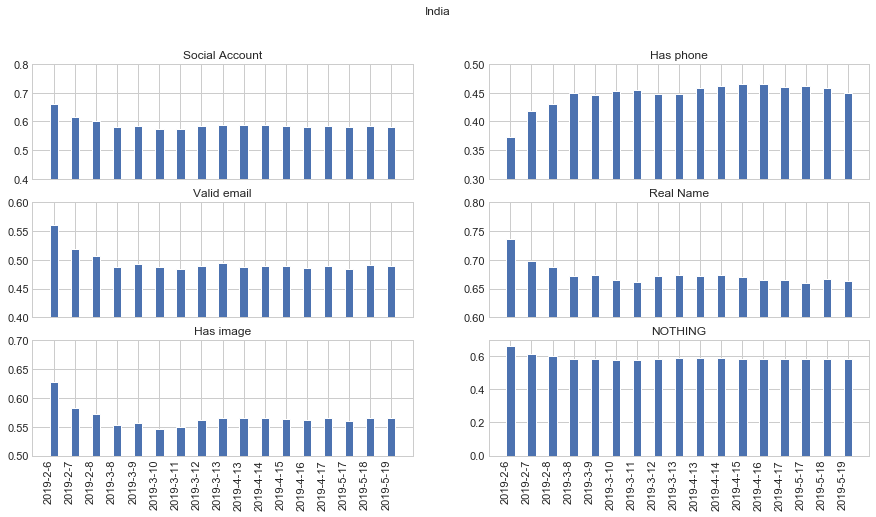

In [9]:
fig , ((ax1,ax2) , (ax3,ax4) , (ax5,ax6)) = plt.subplots(3,2,figsize=(15,8))

ax1.bar(df_2019_05_14.year_month_week, height=df_2019_05_14.percentage_social_account, width=.4)
ax1.set_title("Social Account")
ax1.set_ylim((0.4,0.8))

ax2.bar(df_2019_05_14.year_month_week, height=df_2019_05_14.percentage_tiene_phone, width=.4)
ax2.set_title("Has phone")
ax2.set_ylim((0.3,0.5))

ax3.bar(df_2019_05_14.year_month_week, height=df_2019_05_14.percentage_valid_email, width=.4)
ax3.set_title("Valid email")
ax3.set_ylim((0.4,0.6))

ax4.bar(df_2019_05_14.year_month_week, height=df_2019_05_14.percentage_real_name, width=.4)
ax4.set_title("Real Name")
ax4.set_ylim((0.6,0.8))

ax5.bar(df_2019_05_14.year_month_week, height=df_2019_05_14.percentage_has_photo, width=.4)
ax5.set_title("Has image")
ax5.set_ylim((0.5,0.7))

ax6.bar(df_2019_05_14.year_month_week, height=df_2019_05_14.percentage_social_account, width=.4)
ax6.set_title("NOTHING")

#fig.set_title('India')
fig.suptitle('India')

fig.autofmt_xdate(rotation = 90)

## Pakistan Cohort

-  Second query : 05/14/2019

In [16]:
query = """

SELECT
        extract(year from created_at) as year ,
        extract(month from created_at) as month,
        extract(week from created_at) as week,
        sum(case when ((google_id is null and facebook_id is null) or (google_id = '' and facebook_id = '')) then 0 else 1 end) social_account,
        sum(case when default_phone is null or default_phone='' then 0 else 1 end) as tiene_phone,
        sum(CASE
             WHEN email LIKE '%olx.co%' THEN 0 -- Autogenerado
             WHEN email LIKE '%@olx%' THEN 0 -- Autogenerado
             WHEN email LIKE '%DELETED%' THEN 0 -- Autogenerados
             WHEN email LIKE '%UNLINK%' THEN 0 -- Autogenerados
             WHEN email REGEXP '[0-9]{7}' THEN 0 -- Error de carga
             ELSE 1 END)  as valido_email,
        sum(case when default_person!='OLX User' then 1 else 0 end) as real_name,
        sum(case when b.external_key is not Null and b.external_key>0 then 1 else 0 end) has_photo,
        count(id)
        -- SUBSTRING_INDEX(email,'@',-1) as domain
FROM olxpk.users a
    left join (select distinct external_key from olxpk.images where active=1 and type='user') b on a.id=b.external_key
   where type in ('confirmed')
        and created_at > '2019-01-01'
group by 1,2,3

  
"""

In [17]:
df2 = pd.read_sql_query(query.replace('%', '%%'), connect_sql_pk)

In [23]:
df2.head()

,year,month,week,social_account,tiene_phone,valido_email,real_name,has_photo,count(id)
0,2019,1,0,64880.0,38848.0,54774.0,71816.0,61508.0,100278
1,2019,1,1,95068.0,60195.0,79521.0,105600.0,90168.0,150048
2,2019,1,2,97483.0,61651.0,81101.0,108414.0,92474.0,154096
3,2019,1,3,94572.0,59568.0,78003.0,105149.0,89822.0,149589
4,2019,1,4,69961.0,44508.0,57441.0,77755.0,66889.0,110990


In [28]:
df2_2019_05_14 = df2.copy()

In [31]:
df2_2019_05_14.head()

,year,month,week,social_account,tiene_phone,valido_email,real_name,has_photo,count(id),year_month_week
0,2019,1,0,64880.0,38848.0,54774.0,71816.0,61508.0,100278,2019-1-0
1,2019,1,1,95068.0,60195.0,79521.0,105600.0,90168.0,150048,2019-1-1
2,2019,1,2,97483.0,61651.0,81101.0,108414.0,92474.0,154096,2019-1-2
3,2019,1,3,94572.0,59568.0,78003.0,105149.0,89822.0,149589,2019-1-3
4,2019,1,4,69961.0,44508.0,57441.0,77755.0,66889.0,110990,2019-1-4


In [30]:
df2_2019_05_14.year = df2_2019_05_14.year.astype(str)
df2_2019_05_14.month = df2_2019_05_14.month.astype(str)
df2_2019_05_14.week = df2_2019_05_14.week.astype(str)
df2_2019_05_14['year_month_week'] = df2_2019_05_14['year'] + '-' +  df2_2019_05_14['month'] + '-' + df2_2019_05_14['week'] 
df2_2019_05_14.dtypes

year                object
month               object
week                object
social_account     float64
tiene_phone        float64
valido_email       float64
real_name          float64
has_photo          float64
count(id)            int64
year_month_week     object
dtype: object

In [32]:
df2_2019_05_14['percentage_social_account'] = df2_2019_05_14['social_account'] / df2_2019_05_14['count(id)']
df2_2019_05_14['percentage_tiene_phone'] = df2_2019_05_14['tiene_phone'] / df2_2019_05_14['count(id)']
df2_2019_05_14['percentage_valid_email'] = df2_2019_05_14['valido_email'] / df2_2019_05_14['count(id)']
df2_2019_05_14['percentage_real_name'] = df2_2019_05_14['real_name'] / df2_2019_05_14['count(id)']
df2_2019_05_14['percentage_has_photo'] = df2_2019_05_14['has_photo'] / df2_2019_05_14['count(id)']

In [33]:
df2_2019_05_14.head(200)

,year,month,week,social_account,tiene_phone,valido_email,real_name,has_photo,count(id),year_month_week,percentage_social_account,percentage_tiene_phone,percentage_valid_email,percentage_real_name,percentage_has_photo
0,2019,1,0,64880.0,38848.0,54774.0,71816.0,61508.0,100278,2019-1-0,0.647001,0.387403,0.546222,0.716169,0.613375
1,2019,1,1,95068.0,60195.0,79521.0,105600.0,90168.0,150048,2019-1-1,0.633584,0.401172,0.529970,0.703775,0.600928
2,2019,1,2,97483.0,61651.0,81101.0,108414.0,92474.0,154096,2019-1-2,0.632612,0.400082,0.526302,0.703548,0.600106
3,2019,1,3,94572.0,59568.0,78003.0,105149.0,89822.0,149589,2019-1-3,0.632212,0.398211,0.521449,0.702919,0.600459
4,2019,1,4,69961.0,44508.0,57441.0,77755.0,66889.0,110990,2019-1-4,0.630336,0.401009,0.517533,0.700559,0.602658
5,2019,2,4,26678.0,16888.0,21952.0,29687.0,25459.0,42385,2019-2-4,0.629421,0.398443,0.517919,0.700413,0.600661
6,2019,2,5,98328.0,62360.0,80555.0,109064.0,93868.0,155727,2019-2-5,0.631413,0.400444,0.517283,0.700354,0.602773
7,2019,2,6,94359.0,58960.0,77308.0,104512.0,90289.0,148840,2019-2-6,0.633963,0.396130,0.519403,0.702177,0.606618
8,2019,2,7,88572.0,54657.0,72653.0,98021.0,84320.0,138815,2019-2-7,0.638058,0.393740,0.523380,0.706127,0.607427
9,2019,2,8,56088.0,34729.0,46087.0,62164.0,53681.0,87449,2019-2-8,0.641380,0.397134,0.527016,0.710860,0.613855


TypeError: nan is not a string

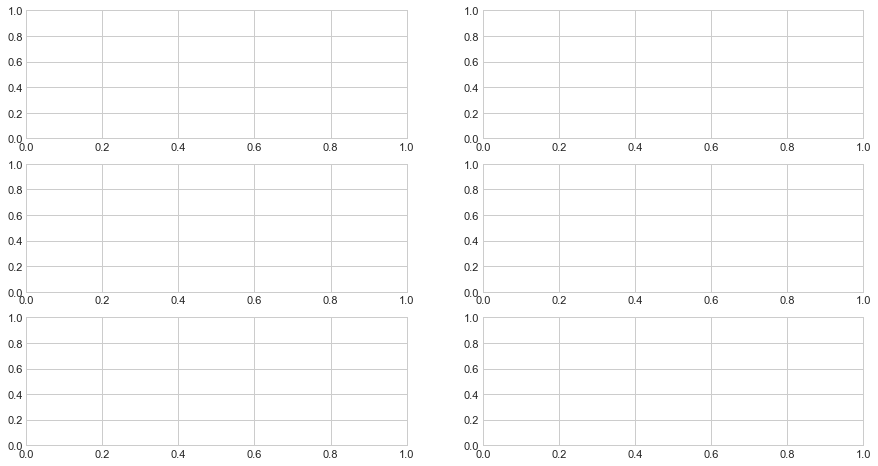

In [22]:
fig , ((ax1,ax2) , (ax3,ax4) , (ax5,ax6)) = plt.subplots(3,2,figsize=(15,8))

ax1.bar(df2_2019_05_14.year_month_week, height=df2_2019_05_14.percentage_social_account, width=.4)
ax1.set_title("Social Account")
ax1.set_ylim((0.4,0.8))

ax2.bar(df2_2019_05_14.year_month_week, height=df2_2019_05_14.percentage_tiene_phone, width=.4)
ax2.set_title("Has phone")
ax2.set_ylim((0.3,0.5))

ax3.bar(df2_2019_05_14.year_month_week, height=df2_2019_05_14.percentage_valid_email, width=.4)
ax3.set_title("Valid email")
ax3.set_ylim((0.4,0.6))

ax4.bar(df2_2019_05_14.year_month_week, height=df2_2019_05_14.percentage_real_name, width=.4)
ax4.set_title("Real Name")
ax4.set_ylim((0.6,0.8))

ax5.bar(df2_2019_05_14.year_month_week, height=df2_2019_05_14.percentage_has_photo, width=.4)
ax5.set_title("Has image")
ax5.set_ylim((0.5,0.7))

ax6.bar(df2_2019_05_14.year_month_week, height=df2_2019_05_14.percentage_social_account, width=.4)
ax6.set_title("NOTHING")

fig.suptitle('Pakistan')

fig.autofmt_xdate(rotation = 90)

## Trying to plotly

In [84]:
import plotly.dashboard_objs as dashboard

import IPython.display
from IPython.display import Image

my_dboard4 = dashboard.Dashboard()

In [119]:
trace1 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_tiene_phone'],
             name= 'Has phone'
)

trace2 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_valid_email'],
             name= 'Has email'
)



data = [trace1 , trace2]
#data2 = [trace0]


layout = dict(title = 'India',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500
             )

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_india')

url_1 = py.plot(fig, filename='profile_completion_india', auto_open=False ,sharing='public')
url_1

C:\Users\OLX - Lucas Dresi\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



'https://plot.ly/~MagicFredes/57'

In [118]:
trace0 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_social_account'],
             name= 'Social account'
            )

trace3 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_real_name'],
             name= 'Has real name'
)

trace4 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_has_photo'],
             name= 'Has photo'
)

data = [trace0 , trace3,trace4]
#data2 = [trace0]


layout = dict(title = 'India',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500
             )

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_india2')

url_2 = py.plot(fig, filename='profile_completion_india2', auto_open=False ,sharing='public')
url_2

C:\Users\OLX - Lucas Dresi\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



'https://plot.ly/~MagicFredes/61'

In [117]:
trace1 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_tiene_phone'],
             name= 'Has phone'
)

trace2 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_valid_email'],
             name= 'Has email'
)

data = [trace1 , trace2]

layout = dict(title = 'Pakistan',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500
             )

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_pakistan')

url_3 = py.plot(fig, filename='profile_completion_pakistan', auto_open=False ,sharing='public')
url_3

C:\Users\OLX - Lucas Dresi\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



'https://plot.ly/~MagicFredes/59'

In [116]:
trace0 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_social_account'],
             name= 'Social account'
            )


trace3 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_real_name'],
             name= 'Has real name'
)

trace4 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_has_photo'],
             name= 'Has photo'
)

data = [trace0 , trace3, trace4]

layout = dict(title = 'Pakistan',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500)
              
            

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_pakistan2')

url_4 = py.plot(fig, filename='profile_completion_pakistan2', auto_open=False ,sharing='public')
url_4

C:\Users\OLX - Lucas Dresi\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



'https://plot.ly/~MagicFredes/63'

In [99]:
import re

def fileId_from_url(url):
    """Return fileId from a url."""
    raw_fileId = re.findall("~[A-z]+/[0-9]+", url)[0][1: ]
    return raw_fileId.replace('/', ':')

fileId_1 = fileId_from_url(url_1)
fileId_2 = fileId_from_url(url_2)
fileId_3 = fileId_from_url(url_3)
fileId_4 = fileId_from_url(url_4)

In [101]:
box_a = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_1,
    'title': 'profile_completion_india'
}

box_b = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_2,
    'title': 'profile_completion_india2'
}

box_c = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_3,
    'title': 'profile_completion_pakistan'
}


box_d = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_4,
    'title': 'profile_completion_pakistan2'
}



In [102]:
my_dboard4.insert(box_a, 'below', 1)

In [103]:
my_dboard4.insert(box_b, 'right', 1)

In [106]:
my_dboard4.insert(box_c, 'below', 1)

In [107]:
my_dboard4.insert(box_d, 'below', 3)

In [120]:
import plotly.plotly as py
py.dashboard_ops.upload(my_dboard4, 'Profile completion')

'https://plot.ly/~MagicFredes/65/untitled-dashboard/'

In [ ]:
# Dashboard Profile completion

import pymysql.cursors

import pandas as pd
import numpy as np
from time import time
import json
from sqlalchemy import create_engine
import re
import datetime
import lifetimes
#import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn-whitegrid')
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import plotly
plotly.tools.set_config_file(world_readable=True , sharing='public')

connect_sql = pymysql.connect(host='prd-db-olxin-replica-1.cnhuszkczyjo.ap-southeast-1.rds.amazonaws.com',
                            user='dev',
                            password='^b6W2vVuM4KJ',
                            db='olxin',
                            charset='utf8mb4',
                            cursorclass=pymysql.cursors.DictCursor)

connect_sql_pk = pymysql.connect(host='prd-db-olxpk-replica-1.cnhuszkczyjo.ap-southeast-1.rds.amazonaws.com',
                            user='dev',
                            password='^b6W2vVuM4KJ',
                            db='olxpk',
                            charset='utf8mb4',
                            cursorclass=pymysql.cursors.DictCursor)

## India Cohort

-  First query : 05/07/2019

query = """

SELECT
        extract(year from created_at) as year  ,
        extract(month from created_at) as month,
        extract(week from created_at) as week,
        sum(case when ((google_id is null and facebook_id is null) or (google_id = '' and facebook_id = '')) then 0 else 1 end) social_account,
        sum(case when default_phone is null or default_phone='' then 0 else 1 end) as tiene_phone,
        sum(CASE
             WHEN email LIKE '%olx.co%' THEN 0 -- Autogenerado
             WHEN email LIKE '%@olx%' THEN 0 -- Autogenerado
             WHEN email LIKE '%DELETED%' THEN 0 -- Autogenerados
             WHEN email LIKE '%UNLINK%' THEN 0 -- Autogenerados
             WHEN email REGEXP '[0-9]{7}' THEN 0 -- Error de carga
             ELSE 1 END)  as valido_email,
        sum(case when default_person!='OLX User' then 1 else 0 end) as real_name,
        sum(case when b.external_key is not Null and b.external_key>0 then 1 else 0 end) has_photo,
        count(id)
        -- SUBSTRING_INDEX(email,'@',-1) as domain
FROM olxin.users a
    left join (select distinct external_key from olxin.images where active=1 and type='user') b on a.id=b.external_key
   where type in ('confirmed')
        and created_at > '2019-02-11'
group by 1,2,3

  
"""

df = pd.read_sql_query(query.replace('%', '%%'), connect_sql)

df_2019_05_07 = df.copy()

df_2019_05_07.year = df.year.astype(str)
df_2019_05_07.month = df.month.astype(str)
df_2019_05_07.week = df.week.astype(str)
df_2019_05_07['year_month_week'] = df_2019_05_07['year'] + '-' +  df_2019_05_07['month'] + '-' + df_2019_05_07['week'] 
df_2019_05_07.dtypes

df_2019_05_07['percentage_social_account'] = df_2019_05_07['social_account'] / df_2019_05_07['count(id)']
df_2019_05_07['percentage_tiene_phone'] = df_2019_05_07['tiene_phone'] / df_2019_05_07['count(id)']
df_2019_05_07['percentage_valid_email'] = df_2019_05_07['valido_email'] / df_2019_05_07['count(id)']
df_2019_05_07['percentage_real_name'] = df_2019_05_07['real_name'] / df_2019_05_07['count(id)']
df_2019_05_07['percentage_has_photo'] = df_2019_05_07['has_photo'] / df_2019_05_07['count(id)']

df_2019_05_07.head(20)

fig , ((ax1,ax2) , (ax3,ax4) , (ax5,ax6)) = plt.subplots(3,2,figsize=(15,8))

ax1.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_social_account, width=.4)
ax1.set_title("Social Account")
ax1.set_ylim((0.4,0.8))

ax2.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_tiene_phone, width=.4)
ax2.set_title("Has phone")
ax2.set_ylim((0.3,0.5))

ax3.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_valid_email, width=.4)
ax3.set_title("Valid email")
ax3.set_ylim((0.4,0.6))

ax4.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_real_name, width=.4)
ax4.set_title("Real Name")
ax4.set_ylim((0.6,0.8))

ax5.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_has_photo, width=.4)
ax5.set_title("Has image")
ax5.set_ylim((0.5,0.7))

ax6.bar(df_2019_05_07.year_month_week, height=df_2019_05_07.percentage_social_account, width=.4)
ax6.set_title("NOTHING")

#fig.set_title('India')
fig.suptitle('India')

fig.autofmt_xdate(rotation = 90)

## Pakistan Cohort

-  First query : 05/07/2019

query = """

SELECT
        extract(year from created_at) as year ,
        extract(month from created_at) as month,
        extract(week from created_at) as week,
        sum(case when ((google_id is null and facebook_id is null) or (google_id = '' and facebook_id = '')) then 0 else 1 end) social_account,
        sum(case when default_phone is null or default_phone='' then 0 else 1 end) as tiene_phone,
        sum(CASE
             WHEN email LIKE '%olx.co%' THEN 0 -- Autogenerado
             WHEN email LIKE '%@olx%' THEN 0 -- Autogenerado
             WHEN email LIKE '%DELETED%' THEN 0 -- Autogenerados
             WHEN email LIKE '%UNLINK%' THEN 0 -- Autogenerados
             WHEN email REGEXP '[0-9]{7}' THEN 0 -- Error de carga
             ELSE 1 END)  as valido_email,
        sum(case when default_person!='OLX User' then 1 else 0 end) as real_name,
        sum(case when b.external_key is not Null and b.external_key>0 then 1 else 0 end) has_photo,
        count(id)
        -- SUBSTRING_INDEX(email,'@',-1) as domain
FROM olxpk.users a
    left join (select distinct external_key from olxpk.images where active=1 and type='user') b on a.id=b.external_key
   where type in ('confirmed')
        and created_at > '2019-02-11'
group by 1,2,3

  
"""

df2 = pd.read_sql_query(query.replace('%', '%%'), connect_sql_pk)

df2_2019_05_07 = df2.copy()

df2_2019_05_07.year = df.year.astype(str)
df2_2019_05_07.month = df.month.astype(str)
df2_2019_05_07.week = df.week.astype(str)
df2_2019_05_07['year_month_week'] = df2_2019_05_07['year'] + '-' +  df2_2019_05_07['month'] + '-' + df2_2019_05_07['week'] 
df2_2019_05_07.dtypes

df2_2019_05_07['percentage_social_account'] = df2_2019_05_07['social_account'] / df2_2019_05_07['count(id)']
df2_2019_05_07['percentage_tiene_phone'] = df2_2019_05_07['tiene_phone'] / df2_2019_05_07['count(id)']
df2_2019_05_07['percentage_valid_email'] = df2_2019_05_07['valido_email'] / df2_2019_05_07['count(id)']
df2_2019_05_07['percentage_real_name'] = df2_2019_05_07['real_name'] / df2_2019_05_07['count(id)']
df2_2019_05_07['percentage_has_photo'] = df2_2019_05_07['has_photo'] / df2_2019_05_07['count(id)']

fig , ((ax1,ax2) , (ax3,ax4) , (ax5,ax6)) = plt.subplots(3,2,figsize=(15,8))

ax1.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_social_account, width=.4)
ax1.set_title("Social Account")
ax1.set_ylim((0.4,0.8))

ax2.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_tiene_phone, width=.4)
ax2.set_title("Has phone")
ax2.set_ylim((0.3,0.5))

ax3.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_valid_email, width=.4)
ax3.set_title("Valid email")
ax3.set_ylim((0.4,0.6))

ax4.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_real_name, width=.4)
ax4.set_title("Real Name")
ax4.set_ylim((0.6,0.8))

ax5.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_has_photo, width=.4)
ax5.set_title("Has image")
ax5.set_ylim((0.5,0.7))

ax6.bar(df2_2019_05_07.year_month_week, height=df2_2019_05_07.percentage_social_account, width=.4)
ax6.set_title("NOTHING")

fig.suptitle('Pakistan')

fig.autofmt_xdate(rotation = 90)

## Trying to plotly

import plotly.dashboard_objs as dashboard

import IPython.display
from IPython.display import Image

my_dboard4 = dashboard.Dashboard()

trace1 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_tiene_phone'],
             name= 'Has phone'
)

trace2 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_valid_email'],
             name= 'Has email'
)



data = [trace1 , trace2]
#data2 = [trace0]


layout = dict(title = 'India',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500
             )

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_india')

url_1 = py.plot(fig, filename='profile_completion_india', auto_open=False ,sharing='public')
url_1

trace0 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_social_account'],
             name= 'Social account'
            )

trace3 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_real_name'],
             name= 'Has real name'
)

trace4 = go.Bar(
             x = df_2019_05_07['year_month_week'] , 
             y = df_2019_05_07['percentage_has_photo'],
             name= 'Has photo'
)

data = [trace0 , trace3,trace4]
#data2 = [trace0]


layout = dict(title = 'India',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500
             )

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_india2')

url_2 = py.plot(fig, filename='profile_completion_india2', auto_open=False ,sharing='public')
url_2

trace1 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_tiene_phone'],
             name= 'Has phone'
)

trace2 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_valid_email'],
             name= 'Has email'
)

data = [trace1 , trace2]

layout = dict(title = 'Pakistan',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500
             )

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_pakistan')

url_3 = py.plot(fig, filename='profile_completion_pakistan', auto_open=False ,sharing='public')
url_3

trace0 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_social_account'],
             name= 'Social account'
            )


trace3 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_real_name'],
             name= 'Has real name'
)

trace4 = go.Bar(
             x = df2_2019_05_07['year_month_week'] , 
             y = df2_2019_05_07['percentage_has_photo'],
             name= 'Has photo'
)

data = [trace0 , trace3, trace4]

layout = dict(title = 'Pakistan',
              yaxis = dict(title='Percentage' , zeroline = False),
              xaxis = dict(title='Registration cohort' , zeroline = False , type='category'),
              width=500,
              height=500)
              
            

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='profile_completion_pakistan2')

url_4 = py.plot(fig, filename='profile_completion_pakistan2', auto_open=False ,sharing='public')
url_4

import re

def fileId_from_url(url):
    """Return fileId from a url."""
    raw_fileId = re.findall("~[A-z]+/[0-9]+", url)[0][1: ]
    return raw_fileId.replace('/', ':')

fileId_1 = fileId_from_url(url_1)
fileId_2 = fileId_from_url(url_2)
fileId_3 = fileId_from_url(url_3)
fileId_4 = fileId_from_url(url_4)

box_a = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_1,
    'title': 'profile_completion_india'
}

box_b = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_2,
    'title': 'profile_completion_india2'
}

box_c = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_3,
    'title': 'profile_completion_pakistan'
}


box_d = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_4,
    'title': 'profile_completion_pakistan2'
}



my_dboard4.insert(box_a, 'below', 1)

my_dboard4.insert(box_b, 'right', 1)

my_dboard4.insert(box_c, 'below', 1)

my_dboard4.insert(box_d, 'below', 3)

import plotly.plotly as py
py.dashboard_ops.upload(my_dboard4, 'Profile completion')